# RA2CE Examples Do It Yourself

Now let's do it yourself!

First do your imports

In [ ]:
import ast
import random
import sys
import webbrowser
import geopandas as gpd
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.pyplot import get_cmap
from matplotlib.colors import to_hex
from pathlib import Path

Create a folder for your project

Then, we will do some basic settings. Keep in mind that you will have to specify the path to your local machine yourself

In [ ]:
sys.path.append('') # path to the ra2ce folder on your local machine

from ra2ce.ra2ce_handler import Ra2ceHandler #import the ra2cehandler to run ra2ce analyses

_network_ini_name = "your input goes here" #set the name for the network.ini
_analysis_ini_name = "your input goes here" #set the name for the analysis.ini



In [ ]:
folder_dir = Path(r'') #Set the path to the folders where you will store your RA2CE project folders

#PS: mind the folder structure!

# Folder structure

Make sure you have the correct folder structure and that the files you want to use are in the right folder. Otherwise, RA2CE will not be able to find the correct files to use.

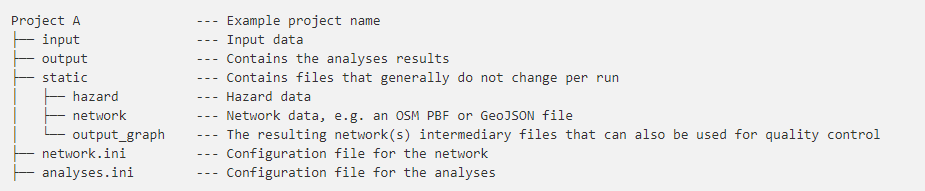

## Configuring a road network from OSM

First, we will need to specify the area for which you want to download your road network.
Therefore, create a .geojson polgyon which you save in the network folder.
Set the **CRS to WGS84 EPSG:4326** 

Specify the way in which you want to create your road network in the network.ini
In this example we will use OSM download. 
Download the road network until **tertiary** roads, or if you want to use a larger area, extract the motorways (also use the links!)

> [project]<br>
name = beira<br>
<br>
[network]<br>
directed = False<br>
**source = ...<br>**
primary_file = None<br>
diversion_file = None<br>
file_id = rfid_c<br>
**polygon = ...<br>**
network_type = drive<br>
**road_types = ...<br>**
save_shp = True<br>
<br>

Now, we tell the program where to find our project folder (by specifying the path to the project folder). The network initialisation file (network.ini) is of interest. Now that we introduced a polygon of a region, we specified the road types and that we want an OSM download, RA2CE can perform this action for us. 

In [ ]:
root_dir = folder_dir /" " #name of the folder which you created for your ra2ce analysis

network_ini = root_dir / _network_ini_name #we set the network_ini_name before, so we can use this now for the project
assert network_ini.is_file() #check whether there is a network.ini

Run the RA2CE analyses by inputting the right arguments.<br>
Do you need both the network and analysis ini?

In [ ]:
handler = Ra2ceHandler(network=... analysis=...)
handler.configure()

Now, inspect your created network!

In [ ]:
#Set the path to YOUR output_graph folder to find the network/graph creation:
path_output_graph = root_dir/" "/" "

Load in the file you are interested in (for example the edges or the nodes). <br>
If you are more comfortable in a GIS, you can also load your data there. 
Notice the different files in the output_graph folder. Inspect them all and see what their differences are.

In [ ]:
#Now we find and inspect the file 'base_graph_edges.gpkg which holds the 'edges' of the network. 
#An edge (or link) of a network (or graph) is one of the connections between the nodes (or vertices) of the network. More information on: https://mathinsight.org/definition/network_edge#:~:text=An%20edge%20(or%20link)%20of,in%20the%20first%20figure%20below.
base_graph_edges = path_output_graph/"base_graph_edges.gpkg"
edges_gdf = gpd.read_file(base_graph_edges, driver = "GPKG")
edges_gdf.head()

Notice how the road network that is downloaded holds the attributes of all these road types that are specified in the network.ini: motorway,motorway_link,primary,primary_link,secondary,secondary_link,tertiary,tertiary_link,residential.

If you want to customize this yourself, you can pick the type of roads you are interested in by choosing from this list. 
For example using only motorway and motorway_link.

In [ ]:
edges_gdf.explore(column='highway', tiles="CartoDB positron")

Now we find and inspect the file 'base_graph_nodes.gpkg which holds the 'nodes' of the network. A node is basically the beginning and end point of an edge. Together, the nodes and edges make up the graph/network

In [ ]:
base_graph_nodes = path_output_graph/"base_graph_nodes.gpkg" #specify where to find the nodes file
nodes_gdf = gpd.read_file(base_graph_nodes, driver = "GPKG") #read in the nodes file


#Plotting nodes and edges together
fig, ax = plt.subplots(figsize=(15, 15))  # Set the figsize as desired
# Set the edges as the base plot
baseplot = edges_gdf.plot(ax=ax, color='grey')
nodes_gdf.plot(ax=baseplot, color='blue', markersize=20)
plt.show()


# Single redundancy test

Now, we will look into the analyses.ini. The following analysis removes each link of the network one at a time. For each disrupted link, a redundancy analysis is performed. It identifies the best existing alternative route or, if there is no redundancy, the lack of alternative routes. This is performed sequentially for each link of the network. 

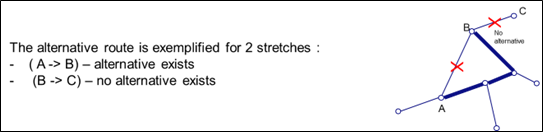

In this example, we perform this analysis for the configured graph in Beira. First, we initialise analysis.ini. The relevant function for this type of analysis is single_link_redundancy. The redundancy of each link is expressed in the total distance (weighing) for the alternative route. You can call this RA2CE function using the analyses.ini:

> [project] <br>
name = beira <br>
 <br>
[analysis1] <br>
name = beira_redundancy <br>
analysis = single_link_redundancy <br>
weighing = distance <br>
save_shp = True <br>
save_csv = True <br>

In [ ]:
root_dir = folder_dir/"beira__single_link_redundancy"

analysis_ini = root_dir / _analysis_ini_name
assert analysis_ini.is_file()

> We configure and run the test by the following methods from the Ra2ceHandler class. No network is introduced to the Ra2ceHandler object to use the existing configure graph created in the previous feature example.

In [ ]:
handler = Ra2ceHandler(network=network_ini, analysis=analysis_ini)
handler.configure()
handler.run_analysis()

> After running the redundancy check, we look at the map representing the roads with and without redundancy. In the second map, we can explore the normal distance between nodes of the graph links (i.e. link's length). In contrast, the last map demonstrates the length of the alternative routes between the nodes of each graph's link when assuming the unavailability of that single link (i.e. attribute alt_dist referring to the alternative distance). 

In [ ]:
analysis_output_folder = root_dir/"output"/"single_link_redundancy" #specify path to output folder

In [ ]:
#just run this, this is now present in the folder with which you ran the analysis
redundancy_gdf = gpd.read_file(analysis_output_folder/"beira_redundancy.gpkg")

#Pick the right columns from the shapefile/geopackage
redundancy_gdf['redundancy'] = redundancy_gdf ['detour'].astype(str)
alt_dist_gpd = redundancy_gdf[redundancy_gdf['detour']==1]

redundancy_gdf.head() #display the attributes of the file

Below, we will first explore the results of the single link redundancy, checking for every single link in the network, whether there is a detour possible (a redundancy). This is based in the idea that if there is no detour possible, this is problematic when a link cannot be used (for example due to a flood). In that case, there is also no detour possible. In the legend '0' means there is no redundancy. '1' means that there is redundancy, a detour is possible for that specific link

In [ ]:
redundant_roads_map = redundancy_gdf.explore(column='redundancy', tiles="CartoDB positron", cmap=['red', 'green'])
display(redundant_roads_map)

#'0' means there is no redundancy
#'1' means that there is redundancy, a detour is possible for that specific link

We can also plot the distance / length of every link in the road network, using the 'length' column

In [ ]:
normal_dist_map = redundancy_gdf.explore(column='length', tiles="CartoDB positron", cmap='winter_r')
display(normal_dist_map)

We can now check how far the alternative distance is for every link in the network. The alternative distance refers to the length of the detour for when the link itself is not available. The distance is given as an attribute to every link itself (i.e. the link receives the distance of the detour as an attribute)

In [ ]:
alt_dist_map = alt_dist_gpd.explore(column='alt_dist', tiles="CartoDB positron", cmap='winter_r')
display(alt_dist_map)

It should be noted that there might be cases where the original distance can be longer than the alternative distance from A (818) to B(828) In the example below, the alternative distance between nodes 818 and 828 (1621) is shorter than the normal length of road 1622. 
When you would inspect the shapefile, you would see this in the column "diff_dist", which refers to the difference in distance between the alternative and the original route from A to B for every link in the road network. The column diff_dist will have negative value in such instances. This implies that the original link is longer than the alternative route. This is purely relevant from a network inspection point of view. In reality, most people will take road 1621 to get from A to B. 

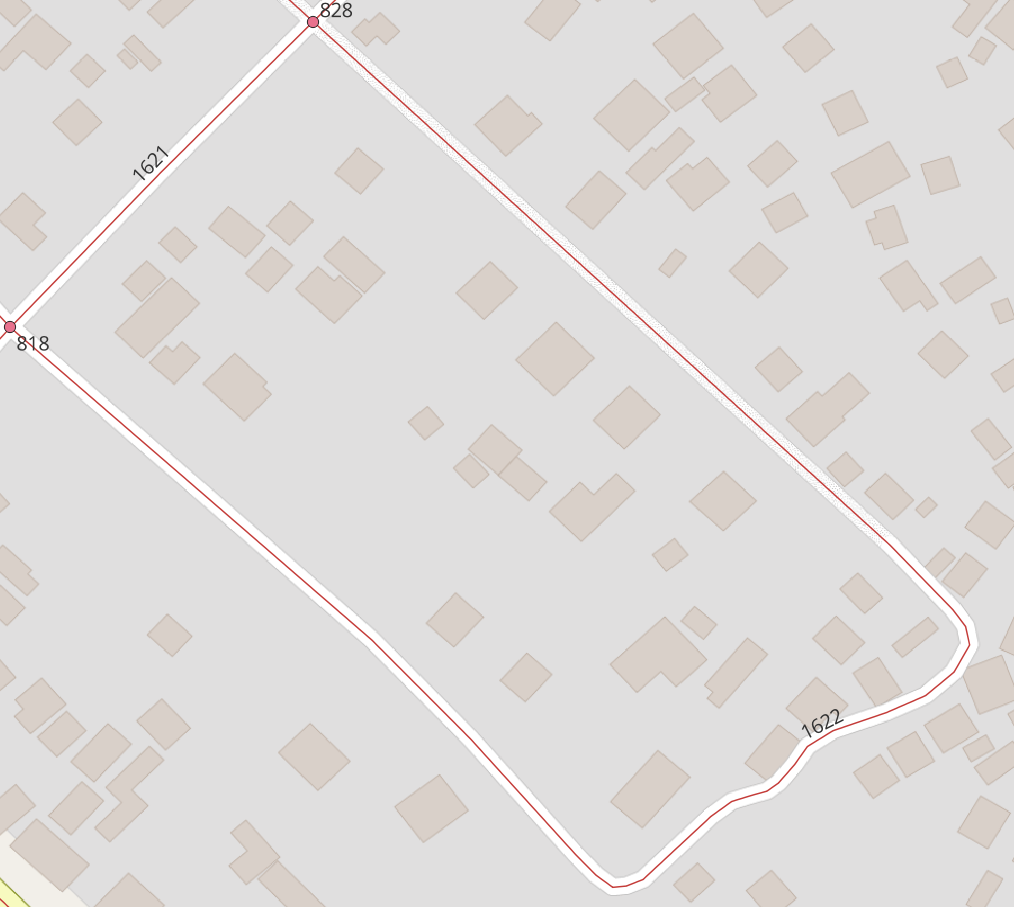

# Origin-Destination, defined origins to destinations

This analysis finds **the shortest (distance-weighed) or quickest (time-weighed) route** from Origins to Destinations. The origins and destinations are specified by the user. 
With origins, we refer to points of origins or starting points. OD-analyses in RA2CE can perform analysis, given user-specified origins and destinations. You can play with different types of origins and destinations, depending on your question of interest.

You can for example compute the optimal routes to all hospitals for every residential home. But you can also find the optimal route to schools for every residential home. Or you could find for every school the optimal route to all hospitals. 

The example below illustrates what that looks like in terms of output: There is an origin, a destination and an optimal route between these. 

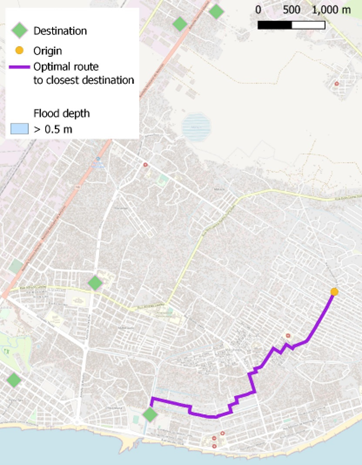

The user needs to specify origins and destinations. This can be done in several ways. For origins, there are global datasets available in the WorldPop database. These can be used as origin points (after a raster to point conversion manually in GIS). Bear in mind that the data needs a specific structure: it should hold an **ID-column** and there should be a field with the **origin_counts** (these can also be 0). 

Set the CRS to **WGS84** EPSG:4326

After creating this data, the user needs to save the data in the static / network folder. 

The same goes for the destinations. The destinations also need an **ID-column** but not an origin count column. Destinations need a **category** column in which you specify the category of a destination.  

We need new network and analysis initialisation files, which include Origin-Destination (OD) matrix and **optimal_route_origin_closest_destination** analysis, respectively.
Navigate to the folder in which you want to perform this analysis, and change the network.ini and the analysis.ini accordingly.

**Network.ini content**
<br>
<br>
> [project]<br>
name = beira<br>
<br>
[network]<br>
directed = False<br>
source = OSM download<br>
primary_file = None<br>
diversion_file = None<br>
file_id = rfid_c<br>
polygon = Extent_Network_wgs84.geojson<br>
network_type = drive<br>
road_types = motorway,motorway_link,primary,primary_link,secondary,secondary_link,tertiary,tertiary_link,residential<br>
save_shp = True<br>
<br>
[origins_destinations]<br>
origins = origins_worldpop_wgs84.shp<br>
destinations = destinations_all_good_wgs84.shp<br>
origins_names = A<br>
destinations_names = B<br>
id_name_origin_destination = OBJECTID<br>
origin_count = POPULATION<br>                         
origin_out_fraction = 1<br>
category = category<br>
<br>
*[hazard]<br>
hazard_map = None<br>
hazard_id = None<br>
hazard_field_name = waterdepth<br>
aggregate_wl = max<br>
hazard_crs = None<br>
<br>
[cleanup]<br>
snapping_threshold = None<br>
segmentation_length = None<br>
merge_lines = True<br>
merge_on_id = False<br>
cut_at_intersections = False<br>*


**Analysis.ini content**
<br>
<br>
> [project] <br>
name = beira <br>
<br>
[analysis1] <br>
name = optimal_route_od <br>
analysis = optimal_route_origin_destination <br>
weighing = distance <br>
save_shp = True <br>
save_csv = True <br>

In [ ]:
root_dir = folder_dir/'beira_optimal_route_od'

network_ini = root_dir / _network_ini_name
assert network_ini.is_file()

analysis_ini = root_dir / _analysis_ini_name
assert analysis_ini.is_file()

Initialise and run the test.

In [ ]:
handler = Ra2ceHandler(network=network_ini, analysis=analysis_ini)
handler.configure()
handler.run_analysis()

> Finally, we visualise the map. We can find the optimal routes between ODs by hovering on the links and investigating the *opt_path* attribute. The optimal_route_od.gpkg is the result of this analysis that contains all optimal routes between all OD pairs.<br>
<br>
> Bellow, we visualise the filtered results for the optimal routes (blue links) from one origin (red node) to all destinations (green nodes). The grey road network shows all the included links. Please note that the origins_filtered and destinations layers introduced below are the modified versions of the origin_destination_table. gpkg data generated in the network configuration step. 

In [ ]:
output_path = root_dir /"output"/"optimal_route_origin_destination" #set the path to the output folder of the analysis
output_graph_path = root_dir/"static"/ "output_graph" #set the path to the output_graph folder which holds the road network 

In [ ]:

base_edges_gdf = gpd.read_file(output_graph_path/'base_graph_edges.gpkg')
base_edges_gdf['grey_links_legend'] = 'All links'
base_edges_map = base_edges_gdf.explore(column='grey_links_legend', tiles="CartoDB positron", cmap=['grey'])

optimal_route_od_filtered_gdf = gpd.read_file(output_path / r'optimal_route_od_filtered.gpkg')
optimal_route_od_filtered_gdf['blue_links_legend'] = 'Optimal routes'
optimal_route_od_filtered_map = optimal_route_od_filtered_gdf.explore(m=base_edges_map, column='blue_links_legend', 
                                                                      tiles="CartoDB positron", cmap=['blue'])

origins_filtered_gdf = gpd.read_file(output_path / r'origins_filtered.gpkg')
origins_filtered_gdf['red_node_legend'] = 'Origin A_257'
origins_filtered_map = origins_filtered_gdf.explore(m=optimal_route_od_filtered_map, column='red_node_legend',
                                                    tiles="CartoDB positron", cmap=['red'], marker_kwds={'radius':7})

destinations_gdf = gpd.read_file(output_path / r'destinations.gpkg')
destinations_gdf['green_nodes_legend'] = 'Destinations'
origins_filtered_map = destinations_gdf.explore(m=origins_filtered_map, column='green_nodes_legend',
                                                tiles="CartoDB positron", cmap=['green'], marker_kwds={'radius':7})

display(origins_filtered_map)


> Now assume a flood event. We perform the **multi_link_origin_closest_destination** analysis to determine what the closest non-disrupted accessible destination is for each origin given the hazard, compared to the situation without a hazard, including the route.

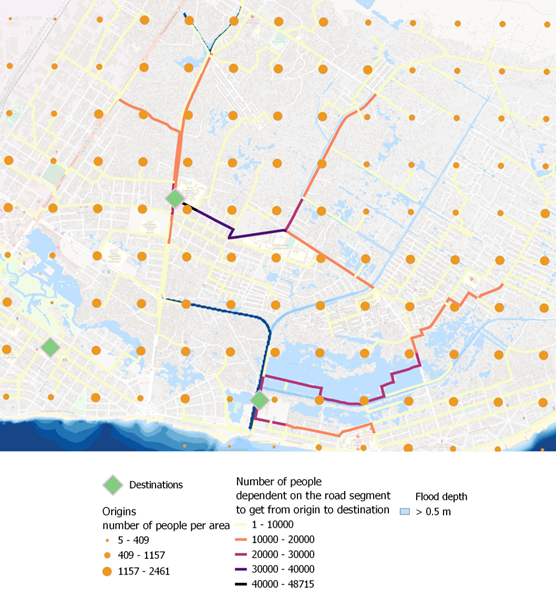

> Let's perform such an analysis. Initialising the .ini files happen in the same way as in the previous examples. For this example, we need a flood map (max_flood_depth.tif in network.ini) and a maximum water depth threshold (threshold in analysis.ini in meters) from which road segments become dysfunctional. Moreover, the aggregate_wl parameter in analysis.ini can be set to either 'max', 'min' or 'mean' to take the maximum, minimum or mean water depth per road segment when the exposure of the roads to a certain hazard (map) is determined.<br>
<br>
Bellow the configured base graph edges, origins (light yellow nodes), destinations, and flood map are presented. Demand nodes are derived from a raster file representing the region's population. That is the reason behind their grid-like placements.

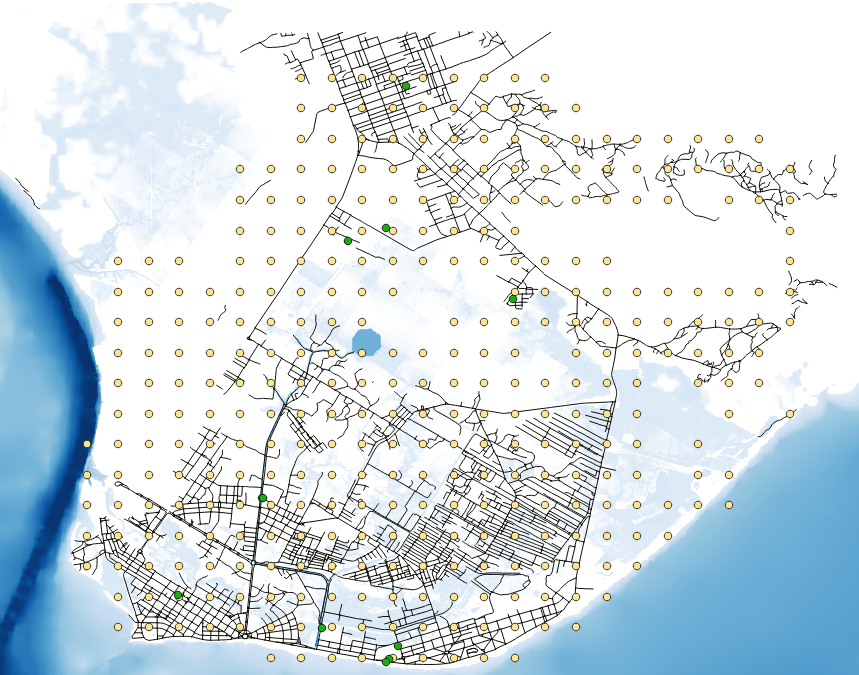

**Network.ini content**
<br>
<br>
> [project]<br>
name = beira<br>
<br>
[network]<br>
directed = False<br>
source = OSM download<br>
primary_file = None<br>
diversion_file = None<br>
file_id = rfid_c<br>
polygon = Extent_Network_wgs84.geojson<br>
network_type = drive<br>
road_types = motorway,motorway_link,primary,primary_link,secondary,secondary_link,tertiary,tertiary_link,residential<br>
save_shp = True<br>
<br>
[origins_destinations]<br>
origins = origins_worldpop_wgs84.shp<br>
destinations = destinations_all_good_wgs84.shp<br>
origins_names = A<br>
destinations_names = B<br>
id_name_origin_destination = OBJECTID<br>
origin_count = POPULATION<br>                         
origin_out_fraction = 1<br>
category = category<br>
<br>
[hazard]<br>
hazard_map = max_flood_depth.tif<br>
hazard_id = None<br>
hazard_field_name = waterdepth<br>
aggregate_wl = max<br>
hazard_crs = EPSG:32736<br>
<br>
*[cleanup]<br>
snapping_threshold = None<br>
segmentation_length = None<br>
merge_lines = True<br>
merge_on_id = False<br>
cut_at_intersections = False<br>*


**analysis.ini content**
<br>
<br>
> [project]<br>
name = beira<br>
<br>
[analysis1]<br>
name = multilink origin closest dest<br>
analysis = multi_link_origin_closest_destination<br>
aggregate_wl = max<br>
threshold = 0.5<br>
weighing = distance<br>
calculate_route_without_disruption = True<br>
save_shp = True<br>
save_csv = True<br>

In [ ]:
root_dir = Path(r'C:\repos\ra2ce\examples\beira_multi_o_closest_d')

network_ini = root_dir / _network_ini_name
assert network_ini.is_file()

analysis_ini = root_dir / _analysis_ini_name
assert analysis_ini.is_file()

> Configure and run:

In [ ]:
handler = Ra2ceHandler(network=network_ini, analysis=analysis_ini)
handler.configure()
handler.run_analysis()

> Now we can explore which origins have access to the destinations (in multilink_origin_closest_dest_origins.gpkg), or available optimal routes from all origins to all destinations, with the number of people using the links under the impact of the introduced hazard (in multilink_origin_closest_dest_optimal_routes_with_hazard.gpkg).

> We visualise the access/no-access states of the origins of educational institutes:

In [ ]:
analysis_output_path = root_dir / r'output\multi_link_origin_closest_destination'
gdf = gpd.read_file(analysis_output_path / 'multilink_origin_closest_dest_origins.gpkg')
gdf.explore(column='education', cmap=['green', 'red'])

> Here, the optimal routes of the A_1 origin to the closest destinations (educational institute and hospital) are visualised.

> Moreover, all optimal routes to B_5 hospital (blue node) destination are demonstrated.

In [ ]:
analysis_output_path = root_dir / r'output\multi_link_origin_closest_destination'
origin_gdf = gpd.read_file(analysis_output_path / 'multilink_origin_closest_dest_origins.gpkg')
destinations_gdf = gpd.read_file(analysis_output_path / 'multilink_origin_closest_dest_destinations.gpkg')
optimal_routes_gdf = gpd.read_file(analysis_output_path / 'multilink_origin_closest_dest_optimal_routes_with_hazard.gpkg')

b_5_gdf = destinations_gdf[destinations_gdf['d_id']=='B_5']
optimal_routes_b_5_gdf = optimal_routes_gdf[optimal_routes_gdf['destination'] == 'B_5']
origins_with_optimal_route_b_5 = origin_gdf[origin_gdf['o_id'].isin(optimal_routes_b_5_gdf['origin'])]

optimal_routes_b_5_map = optimal_routes_b_5_gdf.explore(color='black')
b_5_map = b_5_gdf.explore(m=optimal_routes_b_5_map, color='blue', marker_kwds={'radius':5})
origins_with_optimal_route_b_5.explore(m=b_5_map, color='green', marker_kwds={'radius':5})


# Elaborate example: emergency response

> This example aims to support delivering emergency responses to a flood event in Beira. Emergency responders are interested in gaining insights into the locations of the residential areas impacted by the event, accessible routes to locations that will function as shelters during a part of the recovery phase, and isolated residential areas.<br>
<br>
In this example, educational institutes and hospitals are considered destinations after the flood (as shelters).

> We first identify the required analysis sets. The required insights can be answered by accessibility analysis.<br>
<br>
> 1. To analyse finds the sections of the network that are fully isolated from the rest of the network (also named disconnected islands) due to the hazard-induced disruption, we run the multi_link_isolated_locations analysis. A location is considered ‘isolated’ when part of a fully isolated network (a disconnected island) but not directly affected by the hazard.<br>
<br>
> 2. To determine what the closest non-disrupted accessible destination is for each origin given the hazard, we use multi_link_origin_closest_destination in analyses.ini. This analysis outputs the residential areas which have access to the shelter destinations.
<br>

> Bellow, the networ.ini and analysis.ini are presented respectively:

> [project]<br>
name = beira_emergency_response<br>
<br>
[network]<br>
directed = False<br>
source = OSM download<br>
primary_file = None<br>
diversion_file = None<br>
file_id = rfid_c<br>
polygon = Extent_Network_wgs84.geojson<br>
network_type = drive<br>
road_types = motorway,motorway_link,trunk,trunk_link,primary,primary_link,secondary,secondary_link,tertiary,tertiary_link,unclassified,residential<br>
save_shp = True<br>
<br>
[origins_destinations]<br>
origins = origins_worldpop_wgs84.shp<br>
destinations = destinations_all_good_wgs84.shp<br>
origins_names = A<br>
destinations_names = B<br>
id_name_origin_destination = OBJECTID<br>
origin_count = POPULATION           <br>              
origin_out_fraction = 1<br>
category = category<br>
<br>
[hazard]<br>
hazard_map = max_flood_depth.tif<br>
hazard_id = None<br>
hazard_field_name = waterdepth<br>
aggregate_wl = max<br>
hazard_crs = EPSG:32736<br>
<br>
[isolation]<br>
locations = origins_worldpop_wgs84.shp *# This is needed to investigate the isolated areas* <br>
<br>
*[cleanup]<br>
snapping_threshold = None<br>
pruning_threshold = None<br>
segmentation_length = None<br>
merge_lines = None<br>
ignore_intersections = None<br>*


> [project]<br>
name = beira_emergency_response<br>
<br>
[analysis1]<br>
name = multi-link origin dest test<br>
analysis = multi_link_origin_destination<br>
aggregate_wl = max<br>
threshold = 0.5<br>
weighing = distance<br>
save_shp = True<br>
save_csv = True<br>
<br>
[analysis2]<br>
name = multi-link origin closest destination<br>
analysis = multi_link_origin_closest_destination<br>
aggregate_wl = max<br>
threshold = 0.5<br>
weighing = distance<br>
calculate_route_without_disruption = True<br>
save_shp = True<br>
save_csv = True<br>
<br>
[analysis3]<br>
name = multi-link isolated locations<br>
analysis = multi_link_isolated_locations<br>
aggregate_wl = max<br>
threshold = 0.5<br>
weighing = length<br>
buffer_meters = 500<br>
category_field_name = category<br>
save_shp = True<br>
save_csv = True<br>

> We introduce, configure and run the analysis sets:

In [ ]:
root_dir = Path(r'C:\repos\ra2ce\examples\beira_emergency_response')

network_ini = root_dir / _network_ini_name
assert network_ini.is_file()

analysis_ini = root_dir / _analysis_ini_name
assert analysis_ini.is_file()

In [ ]:
handler = Ra2ceHandler(network=network_ini, analysis=analysis_ini)
handler.configure()
handler.run_analysis()

> **multi_link_isolated_locations results:**

 > 1. *residential areas flooded (> 0.5 m) with waterdepth information and corresponding population in each node's attributes:* Red nodes represent the inundated residential regions.

In [ ]:
analysis_output_path = root_dir / r'output\multi_link_isolated_locations'

affected_origins_gdf = gpd.read_file(analysis_output_path / 'multilink_isolated_locations.gpkg')
affected_origins_gdf['inundated'] = affected_origins_gdf['EV1_ma'].apply(lambda x: '1' if x > 0.5 else '0')

affected_origins_gdf.explore(column='inundated', cmap=['green', 'red'], tiles="CartoDB positron")

> 2. *Isolated residential areas:* <br>
<br> This analysis finds the sections of the network that are fully isolated from the rest of the network (also named disconnected islands), because of network disruption due to a hazard. These locations are not necessarily inundated, but are isolated as disconnected from the larger network due to flooding elsewhere. 

<br>

**Issue with the following map** as if we are passing float, it neads a color spectrum!

In [ ]:
affected_origins_gdf.explore(column='i_EV1', legend=False, tiles="CartoDB positron")

affected_origins_gdf['isolated'] = affected_origins_gdf['i_EV1'].apply(lambda x: '1' if x == 1 else '0')

affected_origins_gdf.explore(column='isolated', cmap=['green', 'red'], tiles="CartoDB positron")

> We overlay the accessible/not-accessible and isolated/connected analysis layers on top of each other. Filled circles show whether the areas are inundated (red and green, respectively). Circles without area colours show whether the areas are isolated (red and green, respectively). By this means, we can trace both inundated and isolated areas.

> Thereafter, we overlay the available roads (green-coloured links), meaning that the maximum water depth is 0.5 meters or lower (threshold in the network.ini).

> Additionally, we overlay the roads that are inundated with a maximum water level of above 0.5 meters on the available road network (green-coloured links).

In [ ]:
inundated_map = affected_origins_gdf.explore(column='inundated', cmap=['darkgreen', 'darkred'], marker_type="circle_marker"
                                             , marker_kwds={'radius':2}, legend=False, tiles="CartoDB positron")
isolated_inundated_map = affected_origins_gdf.explore(m=inundated_map, column='isolated', cmap=['darkgreen', 'darkred'],
                             marker_type="circle", marker_kwds={'radius':150}, legend=False)
display(isolated_inundated_map)

inundated_map = affected_origins_gdf.explore(column='inundated', cmap=['darkgreen', 'darkred'], marker_type="circle_marker"
                                             , marker_kwds={'radius':2}, legend=False)
roads_gdf = gpd.read_file(root_dir / r'static\output_graph\base_graph_hazard_edges.gpkg')
impacted_roads_gdf = roads_gdf[roads_gdf['EV1_ma'] > 0.5]

open_roads_gdf = roads_gdf[roads_gdf['EV1_ma'] <= 0.5]
open_roads_map = open_roads_gdf.explore(m=isolated_inundated_map, color='green')
display(open_roads_map)

impacted_roads_map = impacted_roads_gdf.explore(tiles='CartoDB dark_matter',m=isolated_inundated_map, column='EV1_ma',
                                                cmap='cool', legend_kwds={'caption':'water depth (m)'})
display(impacted_roads_map)

> **multi_link_origin_closest_destination results:**

1. *the access of the residential areas to each type of destination:* We show the residential areas without access to the destinations.

In [ ]:
analysis_output_path = root_dir / r'output\multi_link_origin_closest_destination'

origins_gdf = gpd.read_file(analysis_output_path / 'multilink_origin_closest_dest_origins.gpkg')
no_access_gdf = origins_gdf[origins_gdf['EV1_ma_AD1']=='no access']

no_access_gdf.explore(column='POPULATION', cmap='cool', marker_kwds={'radius':5}, tiles="CartoDB positron")

> 2. *the expected usage levels of the destination nodes:* We present the demand for the accessible destinations (hospitals and educational institutions).

In [ ]:
analysis_output_path = root_dir / r'output\multi_link_origin_closest_destination'

destinations_gdf = gpd.read_file(analysis_output_path / 'multilink_origin_closest_dest_destinations.gpkg')
destinations_gdf['demand'] = destinations_gdf['EV1_ma_PD1'] + destinations_gdf['EV1_ma_PD2'].fillna(0)
accessible_destinations_gdf = destinations_gdf[destinations_gdf['demand'] > 0]

accessible_destinations_gdf.explore(column='demand', cmap='cool', marker_kwds={'radius':5}, tiles="CartoDB positron")

> 3. Bellow, we visualise all optimal routes to accessible destinations.

In [ ]:
analysis_output_path = root_dir / r'output\multi_link_origin_closest_destination'

optimal_routes_hazard_gdf = \
        gpd.read_file(analysis_output_path / 'multilink_origin_closest_dest_optimal_routes_with_hazard.gpkg')
destinations_gdf = gpd.read_file(analysis_output_path / 'multilink_origin_closest_dest_destinations.gpkg')

cmap = get_cmap()
colors = cmap.colors

for i, accessible_destination in enumerate(set(optimal_routes_hazard_gdf['destination'].to_numpy())):
    optimal_routes_destination_gdf = \
        optimal_routes_hazard_gdf[optimal_routes_hazard_gdf['destination'] == accessible_destination]
    color = random.choice(colors)
    layer_color = to_hex(color)
    if i == 0:
        combined_node_link_map = optimal_routes_destination_gdf.explore(color=layer_color, tiles="CartoDB positron")
    else:
        combined_node_link_map = optimal_routes_destination_gdf.explore(m=combined_node_link_map,
                                                                        color=layer_color)
    destination_gdf = destinations_gdf[destinations_gdf['d_id'] == accessible_destination]
    combined_node_link_map = destination_gdf.explore(m=combined_node_link_map, color=layer_color,
                                                     marker_kwds={'radius': 5})
    
display(combined_node_link_map)

# Long-term adaptation planning elaborate example

> Project folder name: Zuidholland_direct_indirect <br>
Aim: Understanding the effects of a flooding event on the road infrastructures <br>
Scenario 1: Run the following on the existing road network <br>
&nbsp;&nbsp;&nbsp;&nbsp;1) Multi-link redundancy analysis (indirect damage analysis) <br>
&nbsp;&nbsp;&nbsp;&nbsp;2) Huizinga direct damage analysis (single or multi-hazard) <br>
<br>
Scenario 2: Edit the road network by adding or changing links (e.g., upgrading links' attribute) or make use of the cut_from_mode functionality (section 6.2.7 of the RA2CE documentation) in the case of a multi-hazard run. Another option can be increasing the water depth threshold (m) relevant to the multi-link redundancy analysis. <br>
&nbsp;&nbsp;&nbsp;&nbsp;Perform the above-mentioned checks.

In [ ]:
# Code ran in the PyCharm Zuidholland_direct_indirect.py file
from pathlib import Path

import geopandas as gpdb
import pytest

from ra2ce.analyses.direct.damage_calculation.damage_network_events import (
    DamageNetworkEvents,
)
from ra2ce.configuration.config_factory import ConfigFactory
from ra2ce.configuration.network.network_config import hazard_handler, NetworkConfig

from ra2ce.graph.networks import Network
from ra2ce.ra2ce_handler import Ra2ceHandler

project_name = Path(__file__).resolve().stem
root_dir = Path(rf'C:\repos\ra2ce\examples\{project_name}')
output_graphs_dir = root_dir / r'static\output_graph'

damage_function = "HZ"
_network_ini_name = "network.ini"

network_ini = root_dir / _network_ini_name
assert network_ini.is_file()

handler = Ra2ceHandler(network=network_ini, analysis=None)
handler.configure()

base_graph_hazard_edges_gdf = gpd.read_file(output_graphs_dir / r'base_graph_hazard_edges.gpkg')

val_cols = [
    col for col in base_graph_hazard_edges_gdf.columns if (col.split("_")[0].isupper())
]

event_gdf = DamageNetworkEvents(base_graph_hazard_edges_gdf, val_cols)
event_gdf.main(damage_function=damage_function)

> **Issue with the direct damage**: <br>
Direct damage calculation, Huizinga function: <br>
&nbsp;&nbsp;&nbsp;&nbsp;a.	network_trails_import in networks.py does not filter on the user-specified road_types. <br>
&nbsp;&nbsp;&nbsp;&nbsp;b.	Direct damage hazard mapping does not publish values for EV_me <br>
&nbsp;&nbsp;&nbsp;&nbsp;(example Zuidholland_direct_indirect, hazard: Delfland_200mm_GHG.tif hazard map) <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;i.	It publishes for the max water depth. <br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;ii.	A fraction of the flooded links are also generated in both the mean and max options. <br>
&nbsp;&nbsp;&nbsp;&nbsp;c.	In damage_network_base.py .lookup() is changed. <br>
<br>
> **Quick fix suggestion**: <br>
&nbsp;&nbsp;&nbsp;&nbsp;Change the coloumn EVi_ma to EVi_me and run the analysis for the demonstration porpuses.